## Setup

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os

### Utility Functions

In [2]:
import matplotlib.pyplot as plt

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

def draw_loss_plot(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def print_predict(model, X_test, y_test, print_row=3):
    # Evaluate the model on the test data using `evaluate`
    print("===",model.__class__.__name__,"===")
    print("Evaluate on test data")
    results = model.evaluate(X_test, y_test, batch_size=128)
    print("test loss, test acc:", results)
    
    predictions = model.predict(X_test)

    for idx, pred in enumerate(predictions[:print_row]):
        
        if (pred>0.5):
            posneg = "\033[92m긍정\033[0m"
        else:
            posneg = "\033[91m부정\033[0m"
            
        escape = ["<PAD>","<BOS>","<END>", "<UNK>"]
        comment = [x for x in get_decoded_sentence(X_test[idx], index_to_word).split() if x not in escape]
        
        print('[{0}:{1:0.3f}] {2}'.format(posneg, pred[0], "".join(comment)))
        
    print()
    import os

def save_word2vec(model):
    model_name= model.__class__.__name__
    # 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
    word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_{}.txt'.format(model_name)
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    return word2vec_file_path


## Data 준비

In [3]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## Load data

### 데이터의 중복 제거

In [4]:
# 중복 데이터 확인
print(train_data[train_data.duplicated("document")])

             id document  label
1058    5890638        4      0
1097    2062443       쵝오      1
1248    3502685       최고      1
1483     775332       최고      1
1707    8009134      재밌다      1
...         ...      ...    ...
149919  6502490        짱      1
149949  3924716    OO 영화      0
149960  6368431     지루하다      0
149966  6735753        1      0
149987  7669621  재미있어요^^      1

[3817 rows x 3 columns]


In [5]:
train_data = train_data.drop_duplicates("document")
test_data = test_data.drop_duplicates("document")
len(train_data[train_data.duplicated("document")])

0

### NaN 결측치 제거

In [6]:
#결측치 확인
train_data.isna().sum()

id          0
document    1
label       0
dtype: int64

In [7]:
train_data = train_data.dropna(axis=0)
test_data = test_data.dropna(axis=0)
train_data.isna().sum()

id          0
document    0
label       0
dtype: int64

### 한국어 토크나이저로 토큰화

In [8]:
from konlpy.tag import Mecab
tokenizer = Mecab()

def tokenize_sentence(sentence):
#     sentence = re.sub(r'[^가-힣 ]', "", sentence)
    return [x[0] for x in tokenizer.pos(sentence)]
    

def tokenize_sentences(sentences):
    token = []
    
    for sentence in sentences:
        token.extend(tokenize_sentence(sentence))

    return token # list(set(token))


### 불용어(Stopwords) 제거

In [9]:
def remove_stopwords(tokens):
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    return [word for word in tokens if word not in stopwords]
    

### 사전word_to_index 구성

In [10]:
def token_to_dic(tokens, num_words=10000):
    
    word_count = {}
    
    for token in tokens:
        try: word_count[token] += 1
        except: word_count[token] = 1
            
    sorted_token = sorted(word_count.items(), key=lambda x:x[1], reverse=True)[:num_words]
    
    word_to_index = { word[0]:idx+3 for idx, word in enumerate(sorted_token) }
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2
    return word_to_index

### 텍스트 스트링을 사전 인덱스 스트링으로 변환

In [11]:
def encoding_sentence(sentence, word_to_index):
    result = [word_to_index["<BOS>"]]
    for token in tokenize_sentence(sentence):
        try : result.append(word_to_index[token])
        except : result.append(word_to_index["<UNK>"])
            
    return result

def encoding_sentences(sentences, word_to_index):
    return [encoding_sentence(x, word_to_index) for x in sentences ]


### X_train, y_train, X_test, y_test, word_to_index 리턴

In [12]:
def load_data(train_data, test_data, num_words=10000):
    token = tokenize_sentences(train_data["document"])
    token = remove_stopwords(token)
    word_to_index = token_to_dic(token, num_words)
    
    train_data["document"] = encoding_sentences(train_data["document"], word_to_index)
    test_data["document"] = encoding_sentences(test_data["document"], word_to_index)
    
    return train_data["document"], train_data["label"], test_data["document"], test_data["label"], word_to_index

### Load data 

In [13]:
num_words = 50000
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words)
index_to_word = {index:word for word, index in word_to_index.items()}

## 인코딩 된 데이터 확인

In [14]:
get_decoded_sentence(X_train[0], index_to_word)

'아 더 빙 . . 진짜 짜증 나 네요 목소리'

In [15]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {0:0.2f}%가 maxlen 설정값 이내에 포함됩니다. '.format((np.sum(num_tokens < max_tokens) / len(num_tokens) * 100)))

문장길이 평균 :  19.72297390690031
문장길이 최대 :  117
문장길이 표준편차 :  15.329503337998032
pad_sequences maxlen :  50
전체 문장의 93.47%가 maxlen 설정값 이내에 포함됩니다. 


## pad_sequences

In [16]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 50)


In [17]:
get_decoded_sentence(X_train[1], index_to_word)

'<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <BOS> 흠 . .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나'

### Training / Validation 데이터 분리

In [18]:
# validation set 10000건 분리
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116182, 50)
(116182,)


### Modeling

In [19]:
vocab_size = len(word_to_index)
word_vector_dim = 16    
embadding_layer = keras.layers.Embedding(vocab_size, word_vector_dim)

In [20]:
class CnnModel(keras.Model):
    
    def __init__(self, embadding_layer = embadding_layer):
        super(CnnModel, self).__init__()
        self.embadding = embadding_layer
        self.conv1 = keras.layers.Conv1D(16, 2, activation='relu')
        self.pooling1 = keras.layers.MaxPooling1D(5)
        self.conv2 = keras.layers.Conv1D(16, 2, activation='relu')
        self.pooling2 = keras.layers.GlobalMaxPooling1D()
        self.dense1 = keras.layers.Dense(8, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
    
    def call(self, input):
        x = self.embadding(input)
        x = self.conv1(x)
        x = self.pooling1(x)
        x = self.conv2(x)
        x = self.pooling2(x)
        x = self.dense1(x)
        return self.dense2(x)
    

In [21]:
class RnnModel(keras.Model):
    
    def __init__(self, embadding_layer = embadding_layer):
        super(RnnModel, self).__init__()
        self.embadding = embadding_layer
        self.lstm = keras.layers.LSTM(8)
        self.dense1 = keras.layers.Dense(8, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
    
    def call(self, input):
        x = self.embadding(input)
        x = self.lstm(x)
        x = self.dense1(x)
        return self.dense2(x)
    

In [22]:
class CnnRnnModel(keras.Model):
    
    def __init__(self, embadding_layer = embadding_layer):
        super(CnnRnnModel, self).__init__()
        self.embadding = embadding_layer
        self.conv1 = keras.layers.Conv1D(16, 2, activation='relu')
        self.pooling1 = keras.layers.MaxPooling1D(5)
        self.lstm = keras.layers.LSTM(8)
        self.dense1 = keras.layers.Dense(8, activation='relu')
        self.dense2 = keras.layers.Dense(1, activation='sigmoid')
    
    def call(self, input):
        x = self.embadding(input)
        x = self.conv1(x)
        x = self.pooling1(x)
        x = self.lstm(x)
        x = self.dense1(x)
        return self.dense2(x)
    

In [23]:
cnn_model = CnnModel()
cnn_model.build(input_shape=(None, word_vector_dim))
cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  800048    
_________________________________________________________________
conv1d (Conv1D)              multiple                  528       
_________________________________________________________________
max_pooling1d (MaxPooling1D) multiple                  0         
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  528       
_________________________________________________________________
global_max_pooling1d (Global multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  136       
_________________________________________________________________
dense_1 (Dense)              multiple                  9 

Epoch 1/5
227/227 [==============================] - 9s 23ms/step - loss: 0.6461 - accuracy: 0.6177 - val_loss: 0.4630 - val_accuracy: 0.7716
Epoch 2/5
227/227 [==============================] - 2s 9ms/step - loss: 0.4191 - accuracy: 0.8025 - val_loss: 0.4490 - val_accuracy: 0.7818
Epoch 3/5
227/227 [==============================] - 2s 9ms/step - loss: 0.3574 - accuracy: 0.8393 - val_loss: 0.4587 - val_accuracy: 0.7783
Epoch 4/5
227/227 [==============================] - 2s 9ms/step - loss: 0.3189 - accuracy: 0.8573 - val_loss: 0.4726 - val_accuracy: 0.7773
Epoch 5/5
227/227 [==============================] - 2s 9ms/step - loss: 0.2823 - accuracy: 0.8754 - val_loss: 0.5018 - val_accuracy: 0.7695


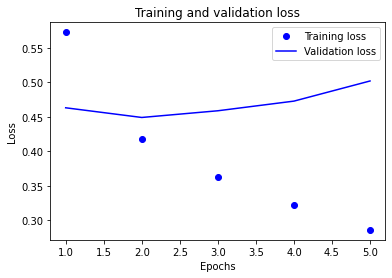

In [24]:
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = cnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

draw_loss_plot(history)

In [25]:
rnn_model = RnnModel()
rnn_model.build(input_shape=(None,1))
rnn_model.summary()

Model: "rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  800048    
_________________________________________________________________
lstm (LSTM)                  multiple                  800       
_________________________________________________________________
dense_2 (Dense)              multiple                  72        
_________________________________________________________________
dense_3 (Dense)              multiple                  9         
Total params: 800,929
Trainable params: 800,929
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
227/227 [==============================] - 5s 15ms/step - loss: 0.6115 - accuracy: 0.6520 - val_loss: 0.3860 - val_accuracy: 0.8375
Epoch 2/5
227/227 [==============================] - 3s 13ms/step - loss: 0.3161 - accuracy: 0.8737 - val_loss: 0.3553 - val_accuracy: 0.8478
Epoch 3/5
227/227 [==============================] - 3s 13ms/step - loss: 0.2654 - accuracy: 0.8960 - val_loss: 0.3567 - val_accuracy: 0.8496
Epoch 4/5
227/227 [==============================] - 3s 13ms/step - loss: 0.2398 - accuracy: 0.9082 - val_loss: 0.3751 - val_accuracy: 0.8451
Epoch 5/5
227/227 [==============================] - 3s 13ms/step - loss: 0.2207 - accuracy: 0.9164 - val_loss: 0.3833 - val_accuracy: 0.8429


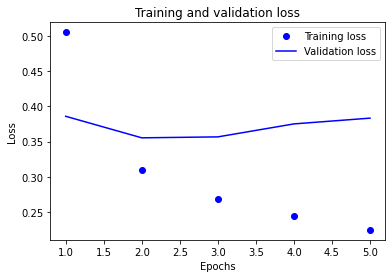

In [26]:
rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = rnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

draw_loss_plot(history)

In [27]:
cnn_rnn_model = CnnRnnModel()
cnn_rnn_model.build(input_shape=(None, word_vector_dim))
cnn_rnn_model.summary()

Model: "cnn_rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  800048    
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  528       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 multiple                  0         
_________________________________________________________________
lstm_1 (LSTM)                multiple                  800       
_________________________________________________________________
dense_4 (Dense)              multiple                  72        
_________________________________________________________________
dense_5 (Dense)              multiple                  9         
Total params: 801,457
Trainable params: 801,457
Non-trainable params: 0
_______________________________________________

Epoch 1/5
227/227 [==============================] - 5s 12ms/step - loss: 0.5767 - accuracy: 0.7470 - val_loss: 0.4687 - val_accuracy: 0.7735
Epoch 2/5
227/227 [==============================] - 2s 10ms/step - loss: 0.3376 - accuracy: 0.8442 - val_loss: 0.4836 - val_accuracy: 0.7740
Epoch 3/5
227/227 [==============================] - 2s 10ms/step - loss: 0.3024 - accuracy: 0.8628 - val_loss: 0.5049 - val_accuracy: 0.7699
Epoch 4/5
227/227 [==============================] - 2s 10ms/step - loss: 0.2769 - accuracy: 0.8739 - val_loss: 0.5288 - val_accuracy: 0.7706
Epoch 5/5
227/227 [==============================] - 2s 10ms/step - loss: 0.2582 - accuracy: 0.8823 - val_loss: 0.5506 - val_accuracy: 0.7696


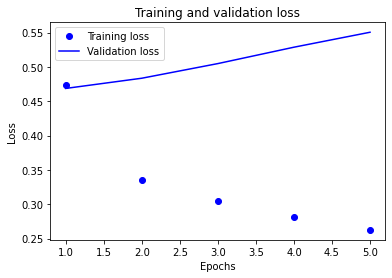

In [28]:
cnn_rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = cnn_rnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

draw_loss_plot(history)

In [29]:
models = [cnn_model, rnn_model, cnn_rnn_model]
for model in models:
    print_predict(model, X_test, y_test)

=== CnnModel ===
Evaluate on test data
385/385 [==============================] - 2s 4ms/step - loss: 0.7666 - accuracy: 0.7186
test loss, test acc: [0.7666115760803223, 0.7185548543930054]
[긍정:0.680] 굳ㅋ
[긍정:0.680] 
[긍정:0.836] 뭐야평점....나쁘진않지만10점짜리더더욱아니잖아

=== RnnModel ===
Evaluate on test data
385/385 [==============================] - 1s 4ms/step - loss: 0.4605 - accuracy: 0.8222
test loss, test acc: [0.4604579210281372, 0.8222430348396301]
[긍정:0.930] 굳ㅋ
[부정:0.133] 
[긍정:0.794] 뭐야평점....나쁘진않지만10점짜리더더욱아니잖아

=== CnnRnnModel ===
Evaluate on test data
385/385 [==============================] - 1s 2ms/step - loss: 0.5564 - accuracy: 0.7653
test loss, test acc: [0.5564091205596924, 0.7653436660766602]
[부정:0.479] 굳ㅋ
[부정:0.479] 
[긍정:0.686] 뭐야평점....나쁘진않지만10점짜리더더욱아니잖아



In [30]:
word_vector_path = save_word2vec(rnn_model)
word_vector_path

'/aiffel/aiffel/sentiment_classification/data/word2vec_RnnModel.txt'

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word_vector_path, binary=False)
print(word_vectors.similar_by_word("너무")[:5])

[('박민영', 0.8483296632766724), ('러브스토리', 0.8287174701690674), ('완전', 0.8277778029441833), ('is', 0.8232713937759399), ('샤아', 0.8226381540298462)]


## Word2Vec

### Load Word2Vec 

In [32]:
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/exploration/ex7/data/ko.bin'

word_vectors = gensim.models.Word2Vec.load(word2vec_path)

In [33]:
word_vectors.similar_by_word("너무")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('워낙', 0.7798625826835632),
 ('굉장히', 0.7619446516036987),
 ('상당히', 0.7366923093795776),
 ('꽤', 0.736415445804596),
 ('너무나', 0.7270296216011047),
 ('매우', 0.7263840436935425),
 ('대단히', 0.6926696300506592),
 ('아주', 0.6923656463623047),
 ('엄청', 0.6503588557243347),
 ('그만큼', 0.647625207901001)]

In [34]:
vocab_size = num_words+3  
word_vector_dim = 200 

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors:
        embedding_matrix[i] = word_vectors[index_to_word[i]]
        

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Model: "rnn_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  10000600  
_________________________________________________________________
lstm_2 (LSTM)                multiple                  6688      
_________________________________________________________________
dense_6 (Dense)              multiple                  72        
_________________________________________________________________
dense_7 (Dense)              multiple                  9         
Total params: 10,007,369
Trainable params: 10,007,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
227/227 [==============================] - 16s 65ms/step - loss: 0.6070 - accuracy: 0.6486 - val_loss: 0.4043 - val_accuracy: 0.8227
Epoch 2/5
227/227 [==============================] - 14s 63ms/step - loss: 0.3683 - accuracy: 0.84

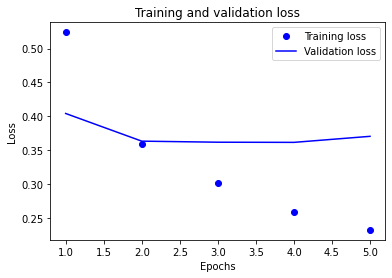

In [35]:
from tensorflow.keras.initializers import Constant

embadding_layer = keras.layers.Embedding(vocab_size, 
                                         word_vector_dim,
                                         embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                         input_length=maxlen, 
                                         trainable=True)

# 학습의 진행
rnn_model = RnnModel(embadding_layer)
rnn_model.build(input_shape=(None,1))
rnn_model.summary()

rnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = rnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

draw_loss_plot(history)

In [36]:
print_predict(rnn_model, X_test, y_test, 10)

=== RnnModel ===
Evaluate on test data
385/385 [==============================] - 2s 4ms/step - loss: 0.3783 - accuracy: 0.8459
test loss, test acc: [0.37832310795783997, 0.8459222316741943]
[긍정:0.969] 굳ㅋ
[긍정:0.523] 
[긍정:0.630] 뭐야평점....나쁘진않지만10점짜리더더욱아니잖아
[부정:0.024] 지루하지않은데완전막장임...돈주고보기....
[부정:0.036] 3D만아니었어도별다섯개줬을텐데..왜3D로나와서제심기불편하게하죠??
[긍정:0.991] 음악주된,최고음악영화
[부정:0.037] 진정쓰레기
[부정:0.335] 마치미국애니에서튀어나온듯창의력없로봇디자인부터,고개젖게한다
[부정:0.009] 갈수록개판되중국영화유치하고내용없음폼잡다끝남말안되무기유치cg아그립다동사서독같영화이건3류아류작다
[긍정:0.960] 이별아픔뒤찾아오새로운인연기쁨But,모든사람그렇지않네..



## 결과

* Conv레이어를 사용한 모델, LSTM 레이어를 사용한 모델, 두가지를 모두 사용한 모델 중 LSTM 레이어를 사용한 모델이 성능이 좋아보인다
* 5 epochs 이상으로 학습하면 Training/Test Loss간의 이격이 커진다.
* 네이버 리뷰 단어들로만 만든 단어 벡터는 단어간의 거리를 제대로 만들어내지 못하는 것으로 보인다
* 한국어 Word2Vec 임베딩을 사용했을 때는 직접 만든 것보다 비슷한 단어를 잘 찾아냈다.
* 한국어 Word2Vec 임베딩을 사용하여 학습했을 때도 생각보다 드라마틱한 성능향상을 보여주진 않았다.